# Development notes

Actions:
* Right now word to vec will use all data to train its embeddings. This should probably be validated by a train, test, validate split.
* Why do I use Adam for my skip gram
* Move the margin in the two tower to be a hyper parameter.

# Step 0a - Configuration

In [19]:
# Configuration
should_use_small_data = True
corpus_filename = "./datasets/ms_marco_corpus.txt"
weights_output_path = "skipgram_weights"

sentencepiece_model_prefix = "ms_marco"
sentencepiece_model_file_name = sentencepiece_model_prefix + ".model"

# Hyper parameters
sentence_piece_vocab_size = 10000

# Word2Vec hyper parameters
embedding_feature_dimension = 128
window_size =2
learning_rate = 0.01
skipgram_epochs = 50
batch_size = 32

# Two tower hyper parameters
two_tower_hidden_size = 128 
vocab_size = 10000
two_tower_learning_rate = 0.001
two_tower_training_epochs = 3 

# Step 0 - Load dependencies

In [4]:
import os
import sentencepiece as spm
from datasets import list_datasets
from datasets import load_dataset
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from tqdm import tqdm

import random

/Users/danielhall/miniconda3/envs/learntosearch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 1 - Load the datasets

In [5]:
datasets_list = list_datasets()
ms_df_dict = load_dataset("ms_marco", "v1.1")
ms_train_df = ms_df_dict['train']
ms_validation_df = ms_df_dict['validation']
ms_test_df = ms_df_dict['test']

# Convert to Pandas
ms_train_df = pd.DataFrame(ms_train_df)
ms_validation_df = pd.DataFrame(ms_validation_df)
ms_test_df = pd.DataFrame(ms_test_df)

print(ms_train_df.head())

if should_use_small_data: 
    # Setup a smaller dataset for debugging purposes
    print("Running with smaller datasets enabled")
    ms_train_df = ms_train_df.iloc[0:1000]
    ms_validation_df = ms_validation_df.iloc[0:600]
    ms_test_df = ms_test_df[0:200]

/var/folders/2r/kktc65rd2cg5yxp_jj0bvxjw0000gn/T/ipykernel_98658/3456321731.py:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  datasets_list = list_datasets()


                                             answers  \
0  [Results-Based Accountability is a disciplined...   
1                                              [Yes]   
2                                    [20-25 minutes]   
3                       [$11 to $22 per square foot]   
4                      [Due to symptoms in the body]   

                                            passages  \
0  {'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]...   
1  {'is_selected': [0, 1, 0, 0, 0, 0, 0], 'passag...   
2  {'is_selected': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]...   
3  {'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 1], '...   
4  {'is_selected': [0, 0, 1, 0, 0, 0, 0, 0], 'pas...   

                                               query  query_id   query_type  \
0                                        what is rba     19699  description   
1                       was ronald reagan a democrat     19700  description   
2  how long do you need for sydney and surroundin...     19701      numeric   
3         

# Step X - Sentence piece preparation

First we create the corpus from the combination from the combination of the the queries and the documents (both positive and negative)

In [11]:
query_string = "query"
passage_string = "passages"
passage_text_string = "passage_text"

# Gather all of queries into one list
all_queries = list(ms_train_df[query_string]) + list(ms_validation_df[query_string]) + list(ms_test_df[query_string])

assert (len(all_queries) == len(ms_train_df) + len(ms_validation_df) + len(ms_test_df))

# Helper function for reading out the data from a given container.
def read_passage_texts_from_data(data_frame):
    passages = data_frame[passage_string]
    texts = [passage[passage_text_string] for passage in passages]
    return texts

train_texts = read_passage_texts_from_data(ms_train_df)
test_texts = read_passage_texts_from_data(ms_test_df)
validation_texts = read_passage_texts_from_data(ms_validation_df)

# Now lets read out all of documents for the corpus
def read_all_documents(data_frame):
    return [entry for passage in data_frame[passage_string] for entry in passage[passage_text_string]]

all_documents = read_all_documents(ms_train_df) + read_all_documents(ms_test_df) + read_all_documents(ms_validation_df)

corpus = all_queries + all_documents

Write the corpus to a file for preview

In [12]:
with open(corpus_filename, "w") as corpus_file:
    for sentence in corpus:
        corpus_file.write(sentence + os.linesep)

Train and generate the sentence piece model using the corpus text

In [8]:
spm.SentencePieceTrainer.train(input=corpus_filename, model_prefix=sentencepiece_model_prefix, vocab_size=sentence_piece_vocab_size)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./datasets/ms_marco_corpus.txt
  input_format: 
  model_prefix: ms_marco
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential

Step X - Generate tokens for the queries and the documents using sentence piece model

In [13]:
sp_model = spm.SentencePieceProcessor()
sp_model.load(sentencepiece_model_file_name)

tokenized_queries = [sp_model.encode_as_pieces(query) for query in all_queries]

id_queries = [[sp_model.piece_to_id(token) for token in query_tokens] for query_tokens in tokenized_queries]

print(tokenized_queries)
print(id_queries)

[['▁what', '▁is', '▁r', 'ba'], ['▁was', '▁r', 'onald', '▁re', 'a', 'g', 'an', '▁a', '▁democrat'], ['▁how', '▁long', '▁do', '▁you', '▁need', '▁for', '▁s', 'y', 'd', 'ney', '▁and', '▁surrounding', '▁areas'], ['▁price', '▁to', '▁install', '▁tile', '▁in', '▁shower'], ['▁why', '▁conversion', '▁observed', '▁in', '▁body'], ['▁where', '▁are', '▁the', '▁lungs', '▁located', '▁in', '▁the', '▁back'], ['▁cost', '▁to', '▁get', '▁a', '▁patent'], ['▁what', '▁does', '▁a', '▁metabolic', '▁acidosis', '▁need', '▁to', '▁reverse', '▁the', '▁condition'], ['▁best', '▁t', 'rag', 'ed', 'ies', '▁of', '▁an', 'cient', '▁gr', 'ee', 'ce'], ['▁what', '▁is', '▁a', '▁conifer'], ['▁in', '▁animals', '▁so', 'matic', '▁cells', '▁are', '▁produced', '▁by', '▁and', '▁game', 'tic', '▁cells', '▁are', '▁produced', '▁by'], ['▁remember', 'ing', '▁the', '▁name', '▁of', '▁the', '▁author', '▁who', '▁wrote', '▁the', '▁cat', '▁in', '▁the', '▁hat'], ['▁how', '▁long', '▁cooking', '▁chicken', '▁legs', '▁in', '▁the', '▁big', '▁easy'], ['▁a

# Step X - Skipgram Word2Vec model implementation

Helper class to prepare the input data to the Skipgram model

In [14]:
def generate_skip_gram_pairs(tokenized_sentences, window_size=2):
    pairs = []
    for sentence in tokenized_sentences:
        for center_word_pos in range(len(sentence)):
            for w in range(-window_size, window_size + 1):
                context_word_pos = center_word_pos + w
                if context_word_pos < 0 or context_word_pos >= len(sentence) or center_word_pos == context_word_pos:
                    continue
                center_word_index = sentence[center_word_pos]
                context_word_index = sentence[context_word_pos]
                pairs.append((center_word_index, context_word_index))
    return pairs

class SkipGramDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, index):
        center, context = self.pairs[index]
        return torch.tensor(center, dtype=torch.long), torch.tensor(context, dtype=torch.long)
    
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dimension):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dimension)
        self.linear = nn.Linear(embedding_dimension, vocab_size)

    def forward(self, target_word):
        embedded = self.embeddings(target_word)
        out = self.linear(embedded)
        log_probabilities = nn.functional.log_softmax(out, dim = 1)
        return log_probabilities


# Step X - Skipgram embeddings trainings

In [21]:
skipgram_pairs = generate_skip_gram_pairs(id_queries, window_size)
skipgram_dataset = SkipGramDataset(skipgram_pairs)
skipgram_dataloader = DataLoader(skipgram_dataset, batch_size=batch_size, shuffle=True)

skipgram_model = SkipGramModel(sentence_piece_vocab_size, embedding_feature_dimension)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(skipgram_model.parameters(), lr = learning_rate)

if not os.path.exists(weights_output_path):
    os.makedirs(weights_output_path)

for epoch in range(skipgram_epochs):
    total_loss = 0
    for center_word, context_word in tqdm(skipgram_dataloader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        log_probs = skipgram_model(center_word)
        loss = loss_function(log_probs, context_word)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    average_loss = total_loss / len(skipgram_dataloader)
    print(f"Epoch {epoch+1}: Total Loss = {total_loss}, Average loss = {average_loss}")

    torch.save(skipgram_model.state_dict(), os.path.join(weights_output_path, f"skip_gram_model_weights_epoch_{epoch+1}.pth"))
    

Epoch 1:   0%|          | 0/1347 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 1347/1347 [00:10<00:00, 125.35it/s]


Epoch 1: Total Loss = 10495.49089050293, Average loss = 7.79175270267478


Epoch 2: 100%|██████████| 1347/1347 [00:10<00:00, 134.09it/s]


Epoch 2: Total Loss = 8729.361948013306, Average loss = 6.480595358584488


Epoch 3: 100%|██████████| 1347/1347 [00:10<00:00, 133.87it/s]


Epoch 3: Total Loss = 8109.417596101761, Average loss = 6.020354562807543


Epoch 4: 100%|██████████| 1347/1347 [00:17<00:00, 76.59it/s] 


Epoch 4: Total Loss = 7765.113181114197, Average loss = 5.764746236907348


Epoch 5: 100%|██████████| 1347/1347 [00:10<00:00, 128.11it/s]


Epoch 5: Total Loss = 7554.8848197460175, Average loss = 5.608674699143294


Epoch 6: 100%|██████████| 1347/1347 [00:11<00:00, 118.72it/s]


Epoch 6: Total Loss = 7426.452002763748, Average loss = 5.513327396261134


Epoch 7: 100%|██████████| 1347/1347 [00:10<00:00, 127.92it/s]


Epoch 7: Total Loss = 7320.625594139099, Average loss = 5.4347628761240525


Epoch 8: 100%|██████████| 1347/1347 [00:10<00:00, 125.27it/s]


Epoch 8: Total Loss = 7254.881269454956, Average loss = 5.3859549142204575


Epoch 9: 100%|██████████| 1347/1347 [00:11<00:00, 113.69it/s]


Epoch 9: Total Loss = 7190.664283514023, Average loss = 5.3382808340861345


Epoch 10: 100%|██████████| 1347/1347 [00:10<00:00, 127.47it/s]


Epoch 10: Total Loss = 7141.10697722435, Average loss = 5.301489960819859


Epoch 11: 100%|██████████| 1347/1347 [00:11<00:00, 120.39it/s]


Epoch 11: Total Loss = 7080.8635239601135, Average loss = 5.2567657935858305


Epoch 12: 100%|██████████| 1347/1347 [00:11<00:00, 122.05it/s]


Epoch 12: Total Loss = 7051.231263160706, Average loss = 5.234767084751823


Epoch 13: 100%|██████████| 1347/1347 [00:13<00:00, 101.73it/s]


Epoch 13: Total Loss = 7005.285980939865, Average loss = 5.200657743830635


Epoch 14: 100%|██████████| 1347/1347 [00:11<00:00, 112.81it/s]


Epoch 14: Total Loss = 6972.939430475235, Average loss = 5.176643972141971


Epoch 15: 100%|██████████| 1347/1347 [00:12<00:00, 112.05it/s]


Epoch 15: Total Loss = 6951.189696550369, Average loss = 5.160497176355137


Epoch 16: 100%|██████████| 1347/1347 [00:10<00:00, 125.85it/s]


Epoch 16: Total Loss = 6914.005102396011, Average loss = 5.1328916870052055


Epoch 17: 100%|██████████| 1347/1347 [00:12<00:00, 110.09it/s]


Epoch 17: Total Loss = 6892.869887113571, Average loss = 5.117201104018984


Epoch 18: 100%|██████████| 1347/1347 [00:10<00:00, 132.21it/s]


Epoch 18: Total Loss = 6865.582411289215, Average loss = 5.0969431412689055


Epoch 19: 100%|██████████| 1347/1347 [00:13<00:00, 99.87it/s] 


Epoch 19: Total Loss = 6847.217506885529, Average loss = 5.083309210753919


Epoch 20: 100%|██████████| 1347/1347 [00:11<00:00, 119.14it/s]


Epoch 20: Total Loss = 6827.355581045151, Average loss = 5.068563905749926


Epoch 21: 100%|██████████| 1347/1347 [00:10<00:00, 126.17it/s]


Epoch 21: Total Loss = 6810.61031627655, Average loss = 5.056132380309243


Epoch 22: 100%|██████████| 1347/1347 [00:13<00:00, 99.93it/s] 


Epoch 22: Total Loss = 6792.438872098923, Average loss = 5.042642072827708


Epoch 23: 100%|██████████| 1347/1347 [00:10<00:00, 125.04it/s]


Epoch 23: Total Loss = 6778.228830337524, Average loss = 5.032092672856366


Epoch 24: 100%|██████████| 1347/1347 [00:11<00:00, 118.54it/s]


Epoch 24: Total Loss = 6769.4918093681335, Average loss = 5.025606391513091


Epoch 25: 100%|██████████| 1347/1347 [00:10<00:00, 129.87it/s]


Epoch 25: Total Loss = 6763.008549213409, Average loss = 5.0207932807820415


Epoch 26: 100%|██████████| 1347/1347 [00:11<00:00, 122.14it/s]


Epoch 26: Total Loss = 6741.160221576691, Average loss = 5.004573289960423


Epoch 27: 100%|██████████| 1347/1347 [00:10<00:00, 128.13it/s]


Epoch 27: Total Loss = 6731.408484697342, Average loss = 4.997333693168034


Epoch 28: 100%|██████████| 1347/1347 [00:10<00:00, 134.38it/s]


Epoch 28: Total Loss = 6722.415138959885, Average loss = 4.990657118752698


Epoch 29: 100%|██████████| 1347/1347 [00:10<00:00, 126.76it/s]


Epoch 29: Total Loss = 6721.7643620967865, Average loss = 4.990173988193606


Epoch 30: 100%|██████████| 1347/1347 [00:11<00:00, 121.52it/s]


Epoch 30: Total Loss = 6718.525177001953, Average loss = 4.987769247959876


Epoch 31: 100%|██████████| 1347/1347 [00:09<00:00, 136.07it/s]


Epoch 31: Total Loss = 6694.0476224422455, Average loss = 4.969597344055119


Epoch 32: 100%|██████████| 1347/1347 [00:10<00:00, 130.11it/s]


Epoch 32: Total Loss = 6701.886715888977, Average loss = 4.975417012538216


Epoch 33: 100%|██████████| 1347/1347 [00:10<00:00, 131.82it/s]


Epoch 33: Total Loss = 6689.82971405983, Average loss = 4.966466008953103


Epoch 34: 100%|██████████| 1347/1347 [00:09<00:00, 136.17it/s]


Epoch 34: Total Loss = 6686.782603740692, Average loss = 4.964203863207641


Epoch 35: 100%|██████████| 1347/1347 [00:10<00:00, 134.02it/s]


Epoch 35: Total Loss = 6680.804754972458, Average loss = 4.9597659650871995


Epoch 36: 100%|██████████| 1347/1347 [00:16<00:00, 83.14it/s] 


Epoch 36: Total Loss = 6672.328269958496, Average loss = 4.953473103161467


Epoch 37: 100%|██████████| 1347/1347 [00:10<00:00, 126.24it/s]


Epoch 37: Total Loss = 6667.399537801743, Average loss = 4.949814059244055


Epoch 38: 100%|██████████| 1347/1347 [00:10<00:00, 133.63it/s]


Epoch 38: Total Loss = 6672.010690450668, Average loss = 4.953237335152687


Epoch 39: 100%|██████████| 1347/1347 [00:10<00:00, 125.28it/s]


Epoch 39: Total Loss = 6657.936924934387, Average loss = 4.94278910537074


Epoch 40: 100%|██████████| 1347/1347 [00:15<00:00, 84.81it/s] 


Epoch 40: Total Loss = 6656.76652431488, Average loss = 4.941920211072666


Epoch 41: 100%|██████████| 1347/1347 [00:14<00:00, 93.96it/s] 


Epoch 41: Total Loss = 6657.431735754013, Average loss = 4.94241405772384


Epoch 42: 100%|██████████| 1347/1347 [00:13<00:00, 98.48it/s] 


Epoch 42: Total Loss = 6653.690936803818, Average loss = 4.939636924130525


Epoch 43: 100%|██████████| 1347/1347 [00:14<00:00, 90.99it/s] 


Epoch 43: Total Loss = 6641.819652557373, Average loss = 4.930823795514011


Epoch 44: 100%|██████████| 1347/1347 [00:12<00:00, 106.35it/s]


Epoch 44: Total Loss = 6642.819362163544, Average loss = 4.931565970425793


Epoch 45: 100%|██████████| 1347/1347 [00:13<00:00, 99.37it/s] 


Epoch 45: Total Loss = 6645.800642967224, Average loss = 4.933779244964532


Epoch 46: 100%|██████████| 1347/1347 [00:10<00:00, 128.75it/s]


Epoch 46: Total Loss = 6632.505878686905, Average loss = 4.923909338297628


Epoch 47: 100%|██████████| 1347/1347 [00:13<00:00, 98.96it/s] 


Epoch 47: Total Loss = 6639.781165122986, Average loss = 4.92931044181365


Epoch 48: 100%|██████████| 1347/1347 [00:10<00:00, 130.61it/s]


Epoch 48: Total Loss = 6635.418314695358, Average loss = 4.926071503114594


Epoch 49: 100%|██████████| 1347/1347 [00:12<00:00, 111.53it/s]


Epoch 49: Total Loss = 6632.78600358963, Average loss = 4.924117300363497


Epoch 50: 100%|██████████| 1347/1347 [00:10<00:00, 122.91it/s]

Epoch 50: Total Loss = 6626.430819749832, Average loss = 4.9193992722715905


Visualize the results of the embeddings using t-SNE

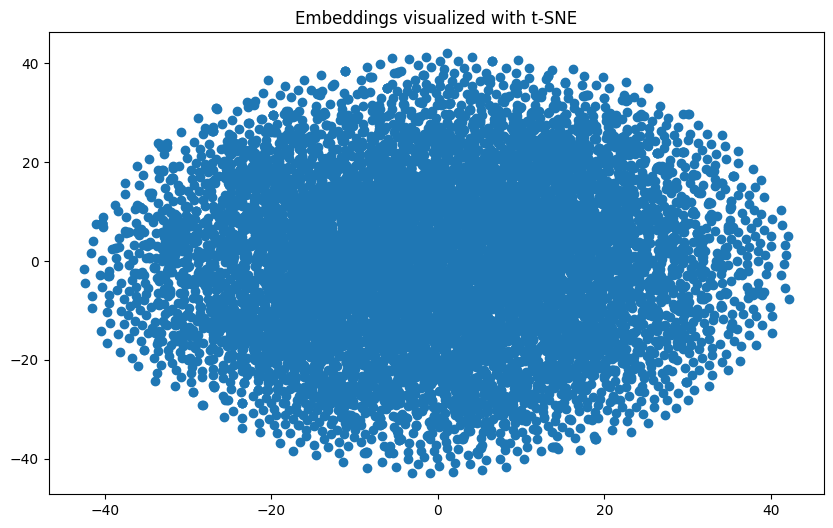

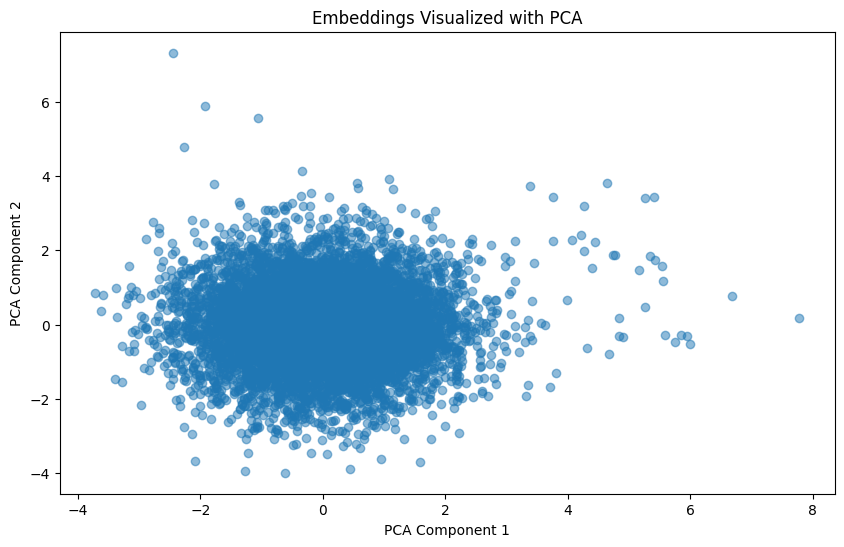

In [22]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

embeddings = skipgram_model.embeddings.weight.data.cpu().numpy()
# Assume embeddings is a matrix of your embeddings
embeddings_tsne = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
plt.title("Embeddings visualized with t-SNE")
plt.show()

# Initialize PCA transformer with 2 components (for 2D visualization)
pca = PCA(n_components=2)

# Fit PCA on the embeddings and transform the embeddings to 2D
embeddings_2d = pca.fit_transform(embeddings)

# Plot the transformed embeddings
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)  # alpha for point transparency
plt.title("Embeddings Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Step X - Prepare the queries using the embeddings for use with the query encoding RNN

First we start off with reading in the embeddings in our model:

In [159]:
skipgram_embeddings_file_path = os.path.join(weights_output_path, f"skip_gram_model_weights_epoch_10.pth")

state_dict = torch.load(skipgram_embeddings_file_path)
embedding_weights_tensor = state_dict['embeddings.weight']

skipgram_embeddings = nn.Embedding(sentence_piece_vocab_size, embedding_feature_dimension)
skipgram_embeddings.weight.data.copy_(embedding_weights_tensor)
skipgram_embeddings.weight.requires_grad = False

Let's create a helper function that helps us genreate tensors of padded embeddings matching the input tokens

Next, using this helper function, we create the inputs for train, test and validate groups

In [205]:
# First we read out the queries and encode them to tokens

def tokenize_entry(entry):
    # Tokenize a single entry using the loaded SentencePiece model
    return sp_model.EncodeAsIds(entry)

def generate_triplets_from_dataset(dataset):
    flat_data = []
    # Step 1: Flatten the data
    for index, row in dataset.iterrows():
        for passage in row['passages']['passage_text']:
            flat_data.append((row['query'], passage))

    print(f"Total flat data entries: {len(flat_data)}")

    # Generating a pool of all passages for selecting negatives
    all_passages = [item[1] for item in flat_data]

    triplets = []
    # Step 2: Generate triplets
    for query, positive in flat_data:
        # Exclude current query's passages from the pool of possible negatives
        possible_negatives = [passage for passage in all_passages if passage != positive]
        if possible_negatives:
            negative_document = random.choice(possible_negatives)
        else:
            # Handle unlikely case where no negative document is available
            negative_document = None
        
        triplets.append((query, positive, negative_document))

    # Convert to DataFrame
    triplets_df = pd.DataFrame(triplets, columns=['query', 'positive_document', 'negative_document'])

    # Step 3: Tokenize each entry in the DataFrame
    triplets_df['query_tokenized'] = triplets_df['query'].apply(tokenize_entry)
    triplets_df['positive_document_tokenized'] = triplets_df['positive_document'].apply(tokenize_entry)
    triplets_df['negative_document_tokenized'] = triplets_df['negative_document'].apply(lambda x: tokenize_entry(x) if x is not None else [])

    return triplets_df

# Assuming dataset is your DataFrame and sp_model is loaded
# dataset = ...
# sp_model = ...
triplets_df = generate_triplets_from_dataset(ms_train_df)

print(triplets_df.head())
print(f"Output table dimensions: {triplets_df.shape}")

Total flat data entries: 8251
         query                                  positive_document  \
0  what is rba  Since 2007, the RBA's outstanding reputation h...   
1  what is rba  The Reserve Bank of Australia (RBA) came into ...   
2  what is rba  RBA Recognized with the 2014 Microsoft US Regi...   
3  what is rba  The inner workings of a rebuildable atomizer a...   
4  what is rba  Results-Based Accountability® (also known as R...   

                                   negative_document      query_tokenized  \
0  You need protein for your muscles, bones, and ...  [95, 11, 559, 1255]   
1  Causes. The rabies virus is a single-stranded ...  [95, 11, 559, 1255]   
2  The basic problem of estrogen dominance is tha...  [95, 11, 559, 1255]   
3  Air conditioner fan motor replacement cost. (C...  [95, 11, 559, 1255]   
4  He is the result of Kryptonian genetic enginee...  [95, 11, 559, 1255]   

                         positive_document_tokenized  \
0  [80, 1345, 3709, 5, 4, 6110, 29, 

In [250]:
def genreate_padded_embeddings_from_token_id_lists(id_list):
    id_list = id_list
    embeddings_list = []
    for ids in id_list:
        output_tensor = torch.tensor(ids, dtype=torch.long)
        with torch.no_grad():
            embeddings = skipgram_embeddings(output_tensor)

        assert output_tensor.shape[0] == len(ids)
        assert embeddings.shape[0] == len(ids)
    
        embeddings_list.append(embeddings)

    assert len(embeddings_list) == len(id_list)

    return pad_sequence(embeddings_list, batch_first=True, padding_value=0)

# Use pad_sequence to pad embeddings
# pad_sequence automatically pads to the longest sequence in the batch
# Set batch_first=True to have output tensor of shape (batch_size, seq_len, feature_number)
padded_queries_embeddings_tensor = genreate_padded_embeddings_from_token_id_lists(triplets_df['query_tokenized'])
padded_positive_documents_embeddings_tensor = genreate_padded_embeddings_from_token_id_lists(triplets_df['positive_document_tokenized'])
padded_negative_documents_embeddings_tensor = genreate_padded_embeddings_from_token_id_lists(triplets_df['negative_document_tokenized'])

print(f"query tensor share: {padded_queries_embeddings_tensor.shape}")
print(f"query tensor share: {padded_positive_documents_embeddings_tensor.shape}")
print(f"query tensor share: {padded_negative_documents_embeddings_tensor.shape}")

query tensor share: torch.Size([8251, 21, 128])
query tensor share: torch.Size([8251, 270, 128])
query tensor share: torch.Size([8251, 270, 128])


# Step X - Setup of the Two tower model

First lets start by defining the two tower calss

In [232]:
class TwoTowerModel(nn.Module):
    def __init__(self, embedding_feature_dimension, hidden_size):
        super(TwoTowerModel, self).__init__()
        # RNN layers for processing the query, positive, and negative documents
        self.query_encoder_rnn = nn.GRU(embedding_feature_dimension, hidden_size, batch_first=True)
        self.pos_doc_encoder_rnn = nn.GRU(embedding_feature_dimension, hidden_size, batch_first=True)
        self.neg_doc_encoder_rnn = nn.GRU(embedding_feature_dimension, hidden_size, batch_first=True)
        self.margin = 0.1  # Triplet margin for loss calculation

    def forward(self, query_tokens, pos_doc_tokens, neg_doc_tokens):
        _, query_hidden = self.query_encoder_rnn(query_tokens)
        query_repr = query_hidden[-1]  # Using the last hidden state as representation
        _, pos_doc_hidden = self.pos_doc_encoder_rnn(pos_doc_tokens)
        pos_doc_repr = pos_doc_hidden[-1]
        _, neg_doc_hidden = self.neg_doc_encoder_rnn(neg_doc_tokens)
        neg_doc_repr = neg_doc_hidden[-1]
        return query_repr, pos_doc_repr, neg_doc_repr
    
    def compute_triplet_loss(self, query_repr, pos_doc_repr, neg_doc_repr):
        cosine_similarity = nn.CosineSimilarity()
        positive_similarity = cosine_similarity(query_repr, pos_doc_repr)
        negative_similarity = cosine_similarity(query_repr, neg_doc_repr)

        raw_losses = self.margin - positive_similarity + negative_similarity

        losses = nn.functional.relu(raw_losses)

        print(f"Positive Similarity: {positive_similarity.mean().item()}, Negative Similarity: {negative_similarity.mean().item()}")
        print(f"Raw Loss (before ReLU): {raw_losses.mean().item()}, Final Loss: {loss.item()}")
    
        return losses.mean()

Next let's setup our dataset helper class:

In [220]:
class TripletsDataset(Dataset):
    def __init__(self, queries, pos_docs, neg_docs):
        self.queries = queries
        self.pos_docs = pos_docs
        self.neg_docs = neg_docs
    
    def __len__(self):
        return len(self.queries)
    
    def __getitem__(self, idx):
        query = self.queries[idx]
        pos_doc = self.pos_docs[idx]
        neg_doc = self.neg_docs[idx]
        return query, pos_doc, neg_doc


Now instantiate the model and perform training

In [233]:
triplets_dataset = TripletsDataset(
    padded_queries_embeddings_tensor,
    padded_positive_documents_embeddings_tensor,
    padded_negative_documents_embeddings_tensor
)

batch_size = 32
data_loader = DataLoader(triplets_dataset, batch_size=batch_size, shuffle=True)


model = TwoTowerModel(embedding_feature_dimension, two_tower_hidden_size)
optimizer = optim.Adam(model.parameters(), lr=two_tower_learning_rate)

for epoch in range(two_tower_training_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_idx, (query_embeddings, pos_doc_embeddings, neg_doc_embeddings) in enumerate(data_loader):
        optimizer.zero_grad()

        # Forward pass
        query_repr, pos_doc_repr, neg_doc_repr = model(query_embeddings, pos_doc_embeddings, neg_doc_embeddings)
        #print(query_embeddings)
        
        # Compute the triplet loss
        loss = model.compute_triplet_loss(query_repr, pos_doc_repr, neg_doc_repr)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{two_tower_training_epochs}], Loss: {epoch_loss / len(data_loader)}')



Positive Similarity: 0.02213166654109955, Negative Similarity: 0.07511162757873535
Raw Loss (before ReLU): 0.15297995507717133, Final Loss: 0.0
Positive Similarity: 0.14566969871520996, Negative Similarity: -0.041366755962371826
Raw Loss (before ReLU): -0.08703647553920746, Final Loss: 0.15297995507717133
Positive Similarity: 0.22286871075630188, Negative Similarity: -0.11888924986124039
Raw Loss (before ReLU): -0.24175797402858734, Final Loss: 0.0
Positive Similarity: 0.2800760865211487, Negative Similarity: -0.17981776595115662
Raw Loss (before ReLU): -0.359893798828125, Final Loss: 0.0
Positive Similarity: 0.32458892464637756, Negative Similarity: -0.2262943685054779
Raw Loss (before ReLU): -0.45088329911231995, Final Loss: 0.0
Positive Similarity: 0.3606306314468384, Negative Similarity: -0.2650487422943115
Raw Loss (before ReLU): -0.525679349899292, Final Loss: 0.0
Positive Similarity: 0.3900141417980194, Negative Similarity: -0.29712823033332825
Raw Loss (before ReLU): -0.5871423

KeyboardInterrupt: 